# Introduction

In this notebook we cover the concept of privacy augmentation by subsampling, that is, if a random sample is accesed instead of accessing the whole database we can reduce the epsilon-delta cost of the access mechanism. This notebook can be seen as a continuation of the notebook [differential_privacy_composition_concepts.ipynb](./differential_privacy_composition_concepts.ipynb). We recommend taking a quick look at the paper [Privacy Amplification by Subsampling: Tight Analyses via Couplings and Divergences](https://arxiv.org/abs/1807.01647).

# Composition & Subsampling

Composition via Privacy Filters and subsampling methods that can be well combined. On the one hand, we can dinamically query our private database until the privacy budget is completely spent and on the other hand, we can increase the number of queries by applying them on a random subsample of the database. Let's recall the adaptive composition experiment that we introduced in [differential_privacy_composition_concepts.ipynb](./differential_privacy_composition_concepts.ipynb)

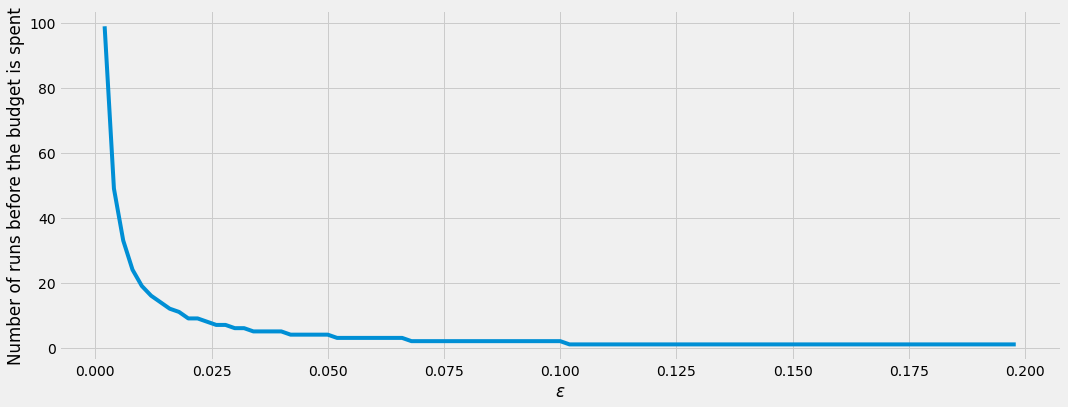

In [12]:
from shfl.private.node import DataNode
from shfl.differential_privacy.composition_dp import AdaptiveDifferentialPrivacy
from shfl.differential_privacy.composition_dp import ExceededPrivacyBudgetError
from shfl.differential_privacy.dp_mechanism import LaplaceMechanism
import numpy as np
import matplotlib.pyplot as plt


def run_adaptive_comp_experiment(global_eps_delta, eps_delta_access):
    # Size of the data stored
    data_size = 1000
    
    # Define a place to store the data
    node_single = DataNode()

    # Store the private data
    node_single.set_private_data(name="secret", data=np.ones(data_size))

    # Choouse your favourite differentially_private_mechanism
    dpm = LaplaceMechanism(sensitivity=1, epsilon=eps_delta_access)

    # Here we are specifing that we want to use composition theorems for Privacy Filters
    # dp-mechanis
    default_data_access = AdaptiveDifferentialPrivacy(global_eps_delta, differentially_private_mechanism=dpm)
    node_single.configure_data_access("secret", default_data_access)

    result_query = []
    while True:
        try:
            # Queries are performed using the Laplace mechanism
            result_query.append(node_single.query(private_property="secret"))
        except ExceededPrivacyBudgetError:
            # At this point we have spent all our privacy budget
            break       
    
    return result_query


global_epsilon_delta = (2e-1, 2e-30)  
epsilon_values = np.arange(2e-3, 2e-1, 2e-3)
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
y_axis=[len(run_adaptive_comp_experiment(global_epsilon_delta, e)) for e in epsilon_values] 
ax.plot(epsilon_values, y_axis)  
ax.set_xlabel('$\epsilon$')
ax.set_ylabel('Number of runs before the budget is spent')

plt.show()

If we access the private data of size $n$ with a ($\epsilon, \delta$)-differentially private mechanism over a random subsample without replacemenet of size $m < n$, then the mechanism is ($\epsilon', \delta'$)-differentially private with:
$$
\epsilon' = \ln \bigg(1 + \frac{m}{n}\bigg(e^{\epsilon}-1\bigg)\bigg) \quad \text{and} \quad \delta' = \frac{m}{n} \delta
$$

If the subsample is performed with replacement, then:

$$
\epsilon' = \ln \bigg(1 + \bigg(1-\bigg(1-\frac{1}{n}\bigg)^{m}\bigg)\bigg(e^{\epsilon}-1\bigg)\bigg) \quad \text{and} \quad \delta' = \sum_{k=1}^m {m\choose k} \bigg(\frac{1}{n}\bigg)^k \bigg(1-\frac{1}{n}\bigg)^{m-k} \delta
$$

Let's see what happens when we modify the experiment to introduce random subsampling:

In [13]:
from shfl.differential_privacy.dp_sampling import SampleWithReplacement
from shfl.differential_privacy.dp_sampling import SampleWithoutReplacement



def run_adaptive_comp_experiment_sampling_with_replacement(global_eps_delta, eps_delta_access, data_size, sample_size):
    # Define a place to store the data
    node_single = DataNode()
    
    # Store the private data
    node_single.set_private_data(name="secret", data=np.ones(data_size))

    # Choouse your favourite differentially_private_mechanism
    dpm = LaplaceMechanism(sensitivity=1, epsilon=eps_delta_access)
    
    # Use a sampling method
    sampling_method = SampleWithReplacement(dpm, sample_size, data_size)

    # Here we are specifing that we want to use composition theorems for Privacy Filters
    # dp-mechanis
    default_data_access = AdaptiveDifferentialPrivacy(global_eps_delta, differentially_private_mechanism=sampling_method)
    node_single.configure_data_access("secret", default_data_access)

    result_query = []
    while True:
        try:
            # Queries are performed using the Laplace mechanism
            result_query.append(node_single.query(private_property="secret"))
        except ExceededPrivacyBudgetError:
            # At this point we have spent all our privacy budget
            break       
    
    return result_query

def run_adaptive_comp_experiment_sampling_without_replacement(global_eps_delta, eps_delta_access, data_size, sample_size):
    # Define a place to store the data
    node_single = DataNode()
    
    # Store the private data
    node_single.set_private_data(name="secret", data=np.ones(data_size))

    # Choouse your favourite differentially_private_mechanism
    dpm = LaplaceMechanism(sensitivity=1, epsilon=eps_delta_access)
    
    # Use a sampling method
    sampling_method = SampleWithoutReplacement(dpm, sample_size, data_size)

    # Here we are specifing that we want to use composition theorems for Privacy Filters
    # dp-mechanis
    default_data_access = AdaptiveDifferentialPrivacy(global_eps_delta, differentially_private_mechanism=sampling_method)
    node_single.configure_data_access("secret", default_data_access)

    result_query = []
    while True:
        try:
            # Queries are performed using the Laplace mechanism
            result_query.append(node_single.query(private_property="secret"))
        except ExceededPrivacyBudgetError:
            # At this point we have spent all our privacy budget
            break       
    
    return result_query

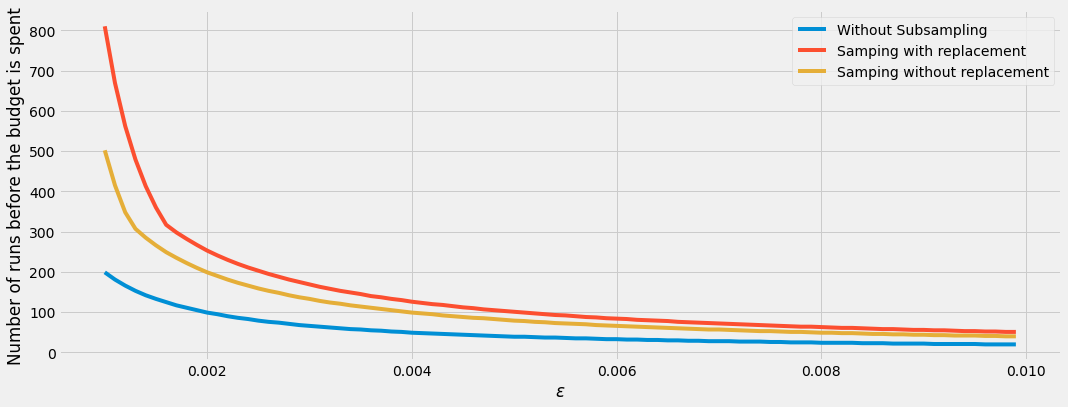

In [14]:
global_epsilon_delta = (2e-1, 2e-30)  
epsilon_values = np.arange(1e-3, 1e-2, 1e-4)
data_size = 1000
sample_size = 500
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
y_axis=[len(run_adaptive_comp_experiment(global_epsilon_delta, e)) for e in epsilon_values] 
ax.plot(epsilon_values, y_axis, label="Without Subsampling")  

y_axis=[len(run_adaptive_comp_experiment_sampling_with_replacement(global_epsilon_delta, e, data_size, sample_size)) for e in epsilon_values] 
ax.plot(epsilon_values, y_axis, label="Samping with replacement") 

y_axis=[len(run_adaptive_comp_experiment_sampling_without_replacement(global_epsilon_delta, e, data_size, sample_size)) for e in epsilon_values] 
ax.plot(epsilon_values, y_axis, label="Samping without replacement") 

ax.set_xlabel('$\epsilon$')
ax.set_ylabel('Number of runs before the budget is spent')

plt.legend(title = "", loc="upper right")
plt.show()

Whoa, the results are incredible but the sample size is quite small. Let's see what happens with the subsampling when we change the sample size:

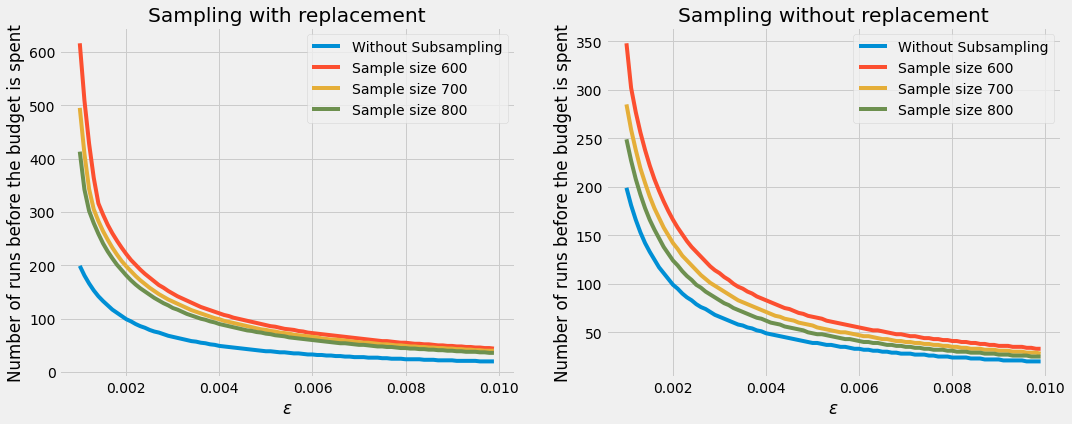

In [15]:
global_epsilon_delta = (2e-1, 2e-30)  
epsilon_values = np.arange(1e-3, 1e-2, 1e-4)
data_size = 1000
samples_size = [600, 700, 800]
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))


y_axis=[len(run_adaptive_comp_experiment(global_epsilon_delta, e)) for e in epsilon_values] 
ax[0].plot(epsilon_values, y_axis, label="Without Subsampling")  
ax[1].plot(epsilon_values, y_axis, label="Without Subsampling")  

for s_size in samples_size:
    y_axis_0=[len(run_adaptive_comp_experiment_sampling_with_replacement(global_epsilon_delta, e, data_size, s_size)) for e in epsilon_values] 
    ax[0].plot(epsilon_values, y_axis_0, label="Sample size {}".format(s_size)) 

    y_axis_1=[len(run_adaptive_comp_experiment_sampling_without_replacement(global_epsilon_delta, e, data_size, s_size)) for e in epsilon_values] 
    ax[1].plot(epsilon_values, y_axis_1, label="Sample size {}".format(s_size)) 

ax[0].set_xlabel('$\epsilon$')
ax[0].set_ylabel('Number of runs before the budget is spent')
ax[0].set_title('Sampling with replacement')
ax[0].legend(title = "", loc="upper right")

ax[1].set_xlabel('$\epsilon$')
ax[1].set_ylabel('Number of runs before the budget is spent')
ax[1].set_title('Sampling without replacement')
ax[1].legend(title = "", loc="upper right")


plt.show()

So we can conclude that even with a relatively big sample (80% of the total size), the improvement over the non-sampling scheme is still great. Particularly, the improvement is grealy noticeable when $\epsilon < 1$, which makes the Gaussian Mechanism ideal, since to achieve ($\epsilon, \delta$)-DP $\epsilon$ must be smaller than 1. That is, the Gaussian Mechanism and the subsampling methods, when applied together, can ensure a minor quantity of noise and a tinier privacy budget expenditure at the cost of accessing a small random subsampling of the data.

In [16]:
from shfl.differential_privacy.dp_sampling import SampleWithReplacement
from shfl.differential_privacy.dp_sampling import SampleWithoutReplacement
from shfl.differential_privacy.dp_mechanism import GaussianMechanism

def run_adaptive_comp_experiment(global_eps_delta, eps_delta_access):
    # Size of the data stored
    data_size = 1000
    
    # Define a place to store the data
    node_single = DataNode()

    # Store the private data
    node_single.set_private_data(name="secret", data=np.ones(data_size))

    # Choouse your favourite differentially_private_mechanism
    dpm = GaussianMechanism(sensitivity=1, epsilon_delta=eps_delta_access)

    # Here we are specifing that we want to use composition theorems for Privacy Filters
    # dp-mechanis
    default_data_access = AdaptiveDifferentialPrivacy(global_eps_delta, differentially_private_mechanism=dpm)
    node_single.configure_data_access("secret", default_data_access)

    result_query = []
    while True:
        try:
            # Queries are performed using the Laplace mechanism
            result_query.append(node_single.query(private_property="secret"))
        except ExceededPrivacyBudgetError:
            # At this point we have spent all our privacy budget
            break       
    
    return result_query

def run_adaptive_comp_experiment_sampling_with_replacement(global_eps_delta, eps_delta_access, data_size, sample_size):
    # Define a place to store the data
    node_single = DataNode()
    
    # Store the private data
    node_single.set_private_data(name="secret", data=np.ones(data_size))

    # Choouse your favourite differentially_private_mechanism
    dpm = GaussianMechanism(sensitivity=1, epsilon_delta=eps_delta_access)
    
    # Use a sampling method
    sampling_method = SampleWithReplacement(dpm, sample_size, data_size)

    # Here we are specifing that we want to use composition theorems for Privacy Filters
    # dp-mechanis
    default_data_access = AdaptiveDifferentialPrivacy(global_eps_delta, differentially_private_mechanism=sampling_method)
    node_single.configure_data_access("secret", default_data_access)

    result_query = []
    while True:
        try:
            # Queries are performed using the Laplace mechanism
            result_query.append(node_single.query(private_property="secret"))
        except ExceededPrivacyBudgetError:
            # At this point we have spent all our privacy budget
            break       
    
    return result_query

def run_adaptive_comp_experiment_sampling_without_replacement(global_eps_delta, eps_delta_access, data_size, sample_size):
    # Define a place to store the data
    node_single = DataNode()
    
    # Store the private data
    node_single.set_private_data(name="secret", data=np.ones(data_size))

    # Choouse your favourite differentially_private_mechanism
    dpm = GaussianMechanism(sensitivity=1, epsilon_delta=eps_delta_access)
    
    # Use a sampling method
    sampling_method = SampleWithoutReplacement(dpm, sample_size, data_size)

    # Here we are specifing that we want to use composition theorems for Privacy Filters
    # dp-mechanis
    default_data_access = AdaptiveDifferentialPrivacy(global_eps_delta, differentially_private_mechanism=sampling_method)
    node_single.configure_data_access("secret", default_data_access)

    result_query = []
    while True:
        try:
            # Queries are performed using the Laplace mechanism
            result_query.append(node_single.query(private_property="secret"))
        except ExceededPrivacyBudgetError:
            # At this point we have spent all our privacy budget
            break       
    
    return result_query

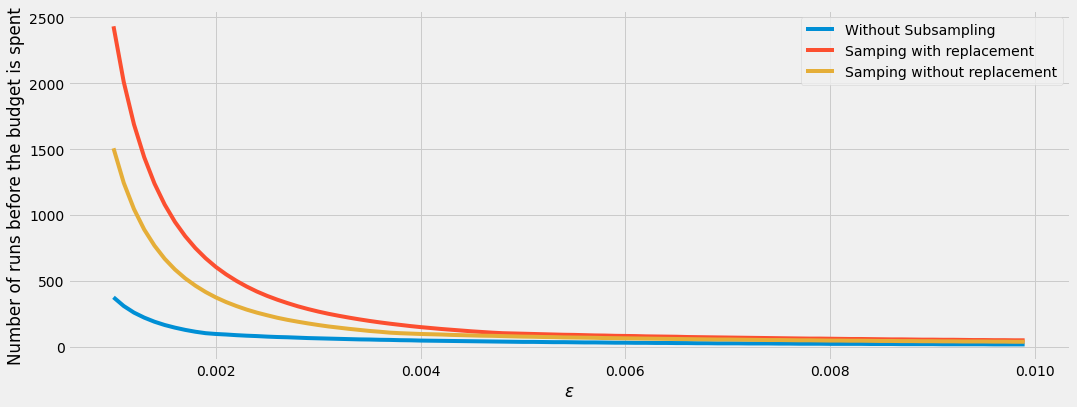

In [17]:
global_epsilon_delta = (2e-1, 2e-10)  
epsilon_values = np.arange(1e-3, 1e-2, 1e-4)
delta_access = 2e-20
data_size = 1000
sample_size = 500
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
y_axis=[len(run_adaptive_comp_experiment(global_epsilon_delta, (e, delta_access))) for e in epsilon_values] 
ax.plot(epsilon_values, y_axis, label="Without Subsampling")  

y_axis=[len(run_adaptive_comp_experiment_sampling_with_replacement(global_epsilon_delta, (e, delta_access), data_size, sample_size)) for e in epsilon_values] 
ax.plot(epsilon_values, y_axis, label="Samping with replacement") 

y_axis=[len(run_adaptive_comp_experiment_sampling_without_replacement(global_epsilon_delta, (e, delta_access), data_size, sample_size)) for e in epsilon_values] 
ax.plot(epsilon_values, y_axis, label="Samping without replacement") 

ax.set_xlabel('$\epsilon$')
ax.set_ylabel('Number of runs before the budget is spent')

plt.legend(title = "", loc="upper right")
plt.show()